Решение:
1. Загрузка всего
2. Осмотр данных(типы, пропуски, баланс целевого признака)
3. Разведочный анализ (корреляции, зависимости, графики)
4. Предподготовка данных(заполнение пропусков, удаление выбросов и лишних признаков, нормализация, кодирование)
5. Начальные модели и их отсеивание
6. Оптимизация моделей

#1 Осмотр данных и загрузка всего необходимого

##1.1 Загрузка

In [ ]:
!pip install catboost
!pip install bayesian-optimization

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, plot_precision_recall_curve, \
                            f1_score, recall_score, precision_score, \
                            confusion_matrix, mean_squared_error, \
                            make_scorer, mean_absolute_error, r2_score

from sklearn.model_selection import cross_validate, \
                                    train_test_split, \
                                    cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
#from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('Train.csv', index_col = 0)
df_test = pd.read_csv('Test.csv', index_col = 0)

In [ ]:
df_train.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,,,,
0,2011-1,385,NaN,1,59,3,0,25.0,NaN,2,0,1,0,0,0,0,0,0,0,0,0,0,0,2489000
1,2011-1,247,NaN,5,53,2,1,15.0,1.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1995000
2,2011-1,115,0.0,7,61,3,0,10.0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3993000
3,2011-1,491,1.0,5,61,3,1,30.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5709000
4,2011-1,623,NaN,3,51,2,1,30.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4374000


In [ ]:
df_test.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
id,,,,,,,,,,,,,,,,,,,,,,,
100000,2012-3,553,1.0,9,35,1,1,25.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100001,2012-3,21,0.0,1,41,2,0,10.0,1.0,3,0,1,0,0,0,0,0,0,0,0,0,0,0
100002,2012-3,203,1.0,2,52,2,1,15.0,1.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
100003,2012-3,332,NaN,7,36,1,0,30.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
100004,2012-3,581,NaN,6,33,1,0,0.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Тип данных во всех колонках (они могут быть обманчивыми)
pd.DataFrame(df_train.dtypes , columns= {'Train data type'}).T

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
Train data type,object,int64,float64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [ ]:
df_train.describe()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
count,100000.000000,70015.00000,100000.000000,100000.000000,100000.00000,100000.000000,94906.000000,69942.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,335.037310,0.53300,5.379220,52.281400,2.10986,0.400360,21.655954,0.496297,2.466570,0.056420,0.627600,0.00742,0.006650,0.003980,0.001850,0.000840,0.007330,0.007830,0.00204,0.00027,0.001780,0.000230,4.805573e+06
std,194.350178,0.58589,4.057459,17.723931,0.82872,0.557131,8.368395,0.499990,1.943183,0.230732,0.483447,0.08582,0.081276,0.062962,0.042972,0.028971,0.085301,0.088141,0.04512,0.01643,0.042153,0.015164,3.760349e+06
min,0.000000,0.00000,1.000000,29.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,4.350000e+05
25%,167.000000,0.00000,2.000000,40.000000,1.00000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2.522000e+06
50%,335.000000,0.00000,4.000000,52.000000,2.00000,0.000000,25.000000,0.000000,2.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,3.910000e+06
75%,504.000000,1.00000,8.000000,60.000000,3.00000,1.000000,30.000000,1.000000,4.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,5.914000e+06
max,671.000000,2.00000,25.000000,217.000000,6.00000,2.000000,30.000000,1.000000,11.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,6.346300e+07


In [ ]:
df_train.nunique()

date             18
street_id       672
build_tech        3
floor            25
area            113
rooms             6
balcon            3
metro_dist        7
g_lift            2
n_photos         12
kw1               2
kw2               2
kw3               2
kw4               2
kw5               2
kw6               2
kw7               2
kw8               2
kw9               2
kw10              2
kw11              2
kw12              2
kw13              2
price         14080
dtype: int64

##1.2 Осмотр пропусков 

In [ ]:
pd.DataFrame({'Count Nan (train)': df_train.isnull().sum().values[:-1],
              'Count Nan on (test)': df_test.isnull().sum().values}, 
             index = df_test.isnull().sum().index)

,Count Nan (train),Count Nan on (test)
date,0,0
street_id,0,0
build_tech,29985,30147
floor,0,0
area,0,0
rooms,0,0
balcon,0,0
metro_dist,5094,4994
g_lift,30058,30122
n_photos,0,0


In [ ]:
# значительное колво пропусков имеют только три признака
df_test.shape, df_train.shape

((100000, 23), (100000, 24))

###1.2.1 Признак *g_lift*

In [ ]:
df_train[df_train.g_lift.isnull()]

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,,,,
0,2011-1,385,NaN,1,59,3,0,25.0,NaN,2,0,1,0,0,0,0,0,0,0,0,0,0,0,2489000
3,2011-1,491,1.0,5,61,3,1,30.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5709000
4,2011-1,623,NaN,3,51,2,1,30.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4374000
7,2011-1,267,1.0,8,52,2,0,30.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2988000
12,2011-1,458,0.0,20,74,3,0,20.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,7502000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,2012-3,378,0.0,12,48,2,0,25.0,NaN,3,0,1,0,0,0,0,0,0,0,0,0,0,0,3134000
99994,2012-3,81,NaN,5,88,3,0,0.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,17353000
99996,2012-3,175,1.0,10,60,3,0,30.0,NaN,5,0,0,0,0,0,0,0,0,0,0,0,0,0,6355000


Попробуем выяснить можно ли заполнить пропуски в *g_lift* с помощью других признаков.

In [ ]:
df_train.g_lift.value_counts()

0.0    35230
1.0    34712
Name: g_lift, dtype: int64

In [ ]:
for col in df_train.columns[10:-1]:
  print(df_train[df_train.g_lift.isnull()][col].value_counts())
  print(df_train[col].value_counts(), '\n')

0    28376
1     1682
Name: kw1, dtype: int64
0    94358
1     5642
Name: kw1, dtype: int64 

1    18869
0    11189
Name: kw2, dtype: int64
1    62760
0    37240
Name: kw2, dtype: int64 

0    29819
1      239
Name: kw3, dtype: int64
0    99258
1      742
Name: kw3, dtype: int64 

0    29831
1      227
Name: kw4, dtype: int64
0    99335
1      665
Name: kw4, dtype: int64 

0    29931
1      127
Name: kw5, dtype: int64
0    99602
1      398
Name: kw5, dtype: int64 

0    30001
1       57
Name: kw6, dtype: int64
0    99815
1      185
Name: kw6, dtype: int64 

0    30042
1       16
Name: kw7, dtype: int64
0    99916
1       84
Name: kw7, dtype: int64 

0    29843
1      215
Name: kw8, dtype: int64
0    99267
1      733
Name: kw8, dtype: int64 

0    29830
1      228
Name: kw9, dtype: int64
0    99217
1      783
Name: kw9, dtype: int64 

0    30000
1       58
Name: kw10, dtype: int64
0    99796
1      204
Name: kw10, dtype: int64 

0    30048
1       10
Name: kw11, dtype: int64
0    99973


С помощью признаков - *ключевых слов* заполнить пропуски в g_lift не получиться, визуально в пропусках такое распределение как и в остальной части. Посмотрим на остальные признаки.

In [ ]:
for col in df_train.columns[:10]:
  print(df_train[df_train.g_lift.isnull()][col].value_counts())
  print(df_train[col].value_counts(), '\n')

2011-6     1745
2012-1     1744
2012-2     1731
2011-9     1703
2011-5     1702
2011-10    1694
2011-3     1685
2011-12    1681
2012-12    1674
2011-8     1659
2012-10    1655
2011-11    1651
2012-3     1650
2011-7     1630
2011-1     1624
2011-4     1620
2012-11    1611
2011-2     1599
Name: date, dtype: int64
2012-1     5678
2011-3     5650
2011-6     5643
2011-9     5608
2011-5     5603
2011-8     5599
2011-7     5595
2011-10    5585
2011-11    5563
2011-1     5557
2012-12    5543
2012-3     5532
2012-2     5515
2012-10    5510
2011-4     5487
2011-12    5484
2011-2     5449
2012-11    5399
Name: date, dtype: int64 

80     65
96     64
206    63
298    62
515    61
       ..
228    29
473    29
146    28
79     27
84     26
Name: street_id, Length: 672, dtype: int64
41     186
578    185
642    181
209    180
69     178
      ... 
520    121
473    119
610    115
103    114
305    114
Name: street_id, Length: 672, dtype: int64 

0.0    10860
1.0     9347
2.0      974
Name: build_te

Тут тоже явных отличий не определить. Тогда перейдем к признаку *build_tech*.

###1.2.2 Признак *build_tech*

In [ ]:
df_train.build_tech.value_counts()

0.0    36000
1.0    30712
2.0     3303
Name: build_tech, dtype: int64

In [ ]:
for col in df_train.columns[1:9]:
  print(df_train[df_train.build_tech.isnull()][col].value_counts())
  print(df_train[df_train.build_tech.notnull()][col].value_counts(), '\n')

578    70
648    67
139    65
185    64
3      64
       ..
146    28
37     28
610    27
598    26
564    26
Name: street_id, Length: 672, dtype: int64
41     139
209    130
299    130
69     129
70     129
      ... 
489     82
335     81
234     79
103     77
448     74
Name: street_id, Length: 672, dtype: int64 

Series([], Name: build_tech, dtype: int64)
0.0    36000
1.0    30712
2.0     3303
Name: build_tech, dtype: int64 

5     3957
1     3876
3     3866
4     3825
2     3802
6     1669
8     1656
9     1600
7     1526
11    1089
12    1078
10    1050
20      97
25      85
15      82
21      81
16      80
24      77
14      75
23      74
17      72
22      71
18      70
19      64
13      63
Name: floor, dtype: int64
3     9111
1     9061
5     9060
4     8986
2     8828
8     3759
9     3717
6     3703
7     3695
10    2661
12    2554
11    2480
19     203
24     198
23     197
13     195
20     193
16     192
22     191
15     188
14     179
25     172
17     171
21     161
1

Здесь тоже значимые отличия в распределениях трудно найти.

###1.2.3 Признак *metro_dist*

In [ ]:
df_train.metro_dist.dtypes

dtype('float64')

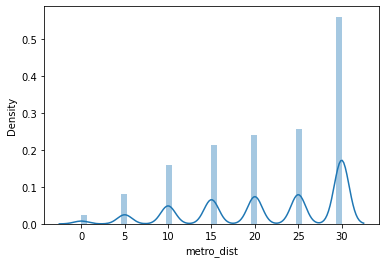

In [ ]:
sns.distplot(df_train[df_train.metro_dist.notnull()].metro_dist)

In [ ]:
df_train.metro_dist.value_counts()

30.0    34670
25.0    15917
20.0    14836
15.0    13179
10.0     9804
5.0      4962
0.0      1538
Name: metro_dist, dtype: int64

In [ ]:
for col in df_train.columns[1:9]:
  print(df_train[df_train.metro_dist.isnull()][col].value_counts())
  print(df_train[df_train.metro_dist.notnull()][col].value_counts(), '\n')

616    16
327    16
414    16
457    15
527    15
       ..
539     2
435     2
103     2
538     1
516     1
Name: street_id, Length: 672, dtype: int64
578    178
41     174
69     172
273    172
642    171
      ... 
103    112
79     112
448    111
305    108
610    107
Name: street_id, Length: 672, dtype: int64 

0.0    1817
1.0    1548
2.0     176
Name: build_tech, dtype: int64
0.0    34183
1.0    29164
2.0     3127
Name: build_tech, dtype: int64 

2     688
5     679
1     651
3     649
4     648
9     301
8     261
6     258
7     253
11    189
10    170
12    169
20     19
24     19
19     17
14     16
23     14
15     14
25     14
13     13
17     13
21     12
22     11
16     10
18      6
Name: floor, dtype: int64
5     12338
3     12328
1     12286
4     12163
2     11942
8      5154
6      5114
9      5016
7      4968
10     3541
12     3463
11     3380
20      271
16      262
23      257
15      256
24      256
22      251
19      250
13      245
25      243
14      238
17

Видимо, чтобы заполнить эти пропуски придется использовать модели.

##1.3 Обработка даты

In [ ]:
df_train.date

id
0        2011-1
1        2011-1
2        2011-1
3        2011-1
4        2011-1
          ...  
99995    2012-3
99996    2012-3
99997    2012-3
99998    2012-3
99999    2012-3
Name: date, Length: 100000, dtype: object

In [ ]:
df_train["date"] = pd.to_datetime(df_train["date"])
df_train['Month'] = pd.DatetimeIndex(df_train['date']).month 

df_test["date"] = pd.to_datetime(df_test["date"])
df_test['Month'] = pd.DatetimeIndex(df_test['date']).month  

def determ_season(ar):
  if ar in [12, 1, 2]: return 1
  elif ar in [3, 4, 5]: return 2
  elif ar in [6, 7, 8]: return 3
  else: return 4

df_train['Season'] = df_train['Month'].apply(determ_season)
df_test['Season'] = df_test['Month'].apply(determ_season)

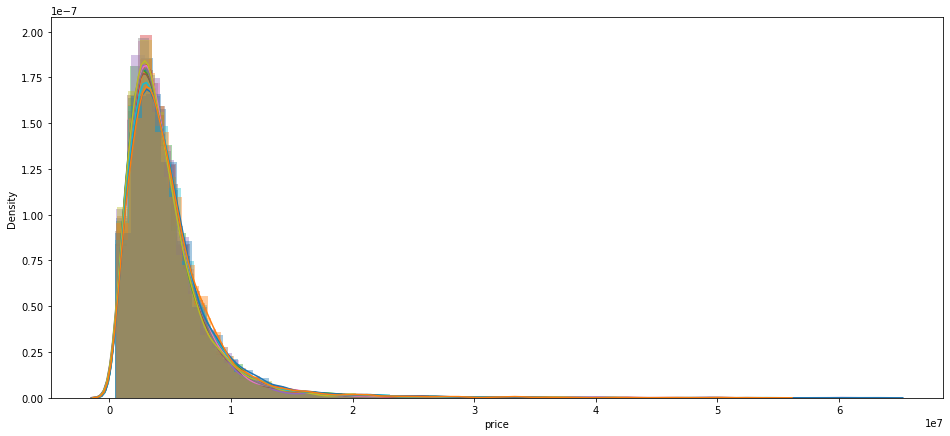

In [ ]:
plt.figure(figsize = (16, 7))
for i in range(1, 13):
  sns.distplot(df_train[df_train['Month'] == i]['price'])

plt.show()

По месяцам все распределения цен не отличаются значимо. Посмотрим на сезоны.

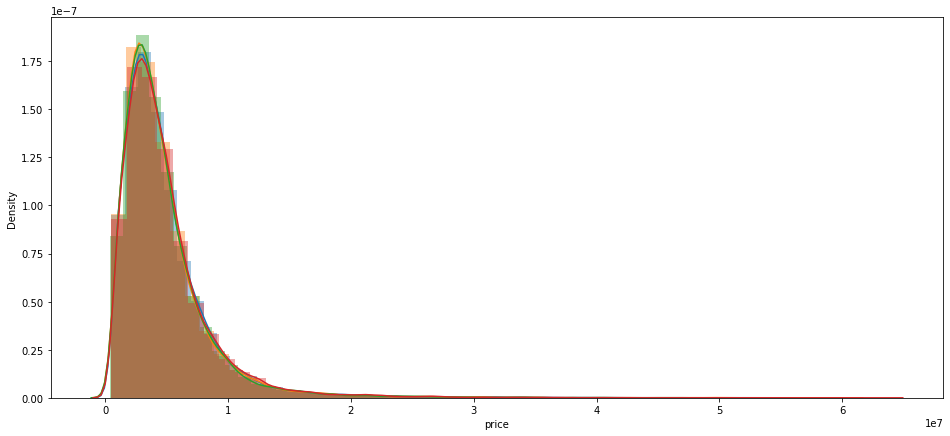

In [ ]:
plt.figure(figsize = (16, 7))
for i in [1, 2, 3, 4]:
  sns.distplot(df_train[df_train['Season'] == i]['price'])

plt.show()

Здесь тоже особых различий в распредениях не видно. Посмотрим какие результаты покажет корреляция.

##1.4 Целевой признак

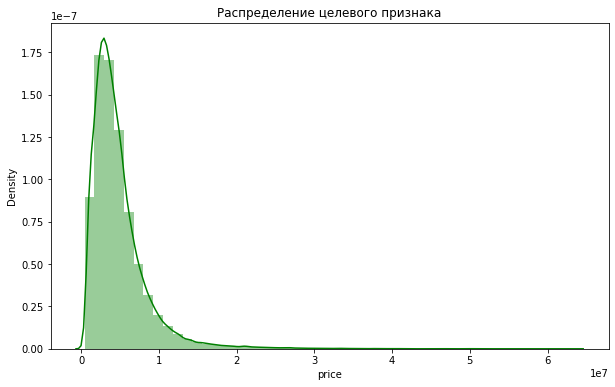

In [ ]:
plt.figure(figsize = (10, 6))
sns.distplot(df_train['price'], color='green')
plt.title('Распределение целевого признака')
plt.show()

Похоже, что распределение имеет лог-нормальное распределение, разумно будет его прологарифмировать для линейных моделей.

In [ ]:
cat_features = df_train.nunique()[df_train.nunique() < 15].index
num_features = df_train.nunique()[df_train.nunique() > 15].index

In [ ]:
df_train.corr()
# таюлица корреляций

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,Month,Season
street_id,1.000000,-0.009903,0.005566,-0.003193,-0.002719,-0.006557,-0.009553,0.000040,0.002767,-0.001516,-0.000122,0.003700,0.003638,-0.000109,0.001769,0.004069,-0.000880,0.001805,0.002042,-0.001957,-0.002698,-0.002504,-0.018267,0.000529,-0.000154
build_tech,-0.009903,1.000000,0.208540,0.325082,0.117525,0.786932,-0.020350,0.004660,0.023556,0.000484,-0.029462,-0.078235,-0.074948,-0.056498,-0.039837,-0.026195,0.068748,0.070600,0.034773,0.012422,0.103749,0.036653,0.389017,-0.001875,-0.004537
floor,0.005566,0.208540,1.000000,0.154219,-0.007183,0.161713,-0.010133,0.007353,-0.006983,-0.001309,-0.043659,-0.051733,-0.007768,0.019340,0.010487,0.059053,-0.052035,0.023518,0.015002,0.006565,0.070835,0.006221,0.206408,-0.002797,-0.000084
area,-0.003193,0.325082,0.154219,1.000000,0.791903,0.258230,-0.007602,0.000100,0.164341,-0.004107,-0.054317,-0.043765,-0.022014,-0.015359,0.010254,0.006356,-0.002548,-0.001538,0.089378,0.037068,0.022646,0.054640,0.685167,-0.003607,-0.005492
rooms,-0.002719,0.117525,-0.007183,0.791903,1.000000,0.095595,-0.005557,0.001410,0.209591,-0.003757,-0.003415,-0.013993,-0.013074,-0.007038,-0.006269,-0.005093,0.009969,0.012866,0.023959,0.008838,-0.011896,0.018679,0.388511,-0.004454,-0.007372
balcon,-0.006557,0.786932,0.161713,0.258230,0.095595,1.000000,-0.014762,-0.000954,0.015356,0.000713,-0.025492,-0.062132,-0.058797,-0.045426,-0.030937,-0.020836,0.051245,0.056311,0.025192,0.012225,0.079515,0.036447,0.309391,0.001277,-0.005169
metro_dist,-0.009553,-0.020350,-0.010133,-0.007602,-0.005557,-0.014762,1.000000,-0.000318,0.003495,0.000150,-0.005014,0.010239,-0.002114,-0.001810,0.000055,-0.001903,-0.005023,-0.001844,-0.000827,-0.005578,0.003677,-0.003367,-0.116427,0.000635,-0.000991
g_lift,0.000040,0.004660,0.007353,0.000100,0.001410,-0.000954,-0.000318,1.000000,0.005239,0.001443,-0.003133,-0.005630,-0.005937,-0.003451,0.002324,0.002066,-0.001361,0.008881,-0.005300,-0.002636,0.003051,0.007250,0.001993,-0.002095,-0.001276
n_photos,0.002767,0.023556,-0.006983,0.164341,0.209591,0.015356,0.003495,0.005239,1.000000,0.031864,-0.010261,0.003166,0.004162,0.008035,0.002836,0.005117,0.008627,0.004710,0.005796,0.004511,0.003168,0.005861,0.184555,-0.002629,-0.001492
kw1,-0.001516,0.000484,-0.001309,-0.004107,-0.003757,0.000713,0.000150,0.001443,0.031864,1.000000,0.000187,-0.000436,0.005056,-0.000313,0.002584,-0.002602,0.000835,0.002372,-0.001450,-0.004019,-0.000044,0.004865,0.015609,0.003201,0.002010


In [ ]:
df_train.drop(['date'], axis = 1, inplace = True)
df_test.drop(['date'], axis = 1, inplace = True)

Попробуем найти новые признаки с хорошей корреляцией.

In [ ]:
x1, x2, x3, x4, x5, y1 = df_train.area, df_train.floor, df_train.rooms, df_train.build_tech, df_train.balcon, df_train.price

In [ ]:
np.where(x5 > 5, x5**2, x5), y1.values

(array([0, 1, 0, ..., 1, 1, 1]),
 array([2489000, 1995000, 3993000, ..., 6695000, 2544000, 3294000]))

In [ ]:
y1.corr(x1*x2**0.07), y1.corr(x3**3*x5)

(0.6925327123605491, 0.4733709065312923)

In [ ]:
for x in x1, x2, x3, x4, x5:
  print(x.name, y1.corr(x))

area 0.6851672903977452
floor 0.20640801614344462
rooms 0.3885109969946494
build_tech 0.38901714443906305
balcon 0.30939115806138223


Использование этих признаков не дало значимо лучших результатов(установлено экспериментально).

##1.5 Поиск выбросов

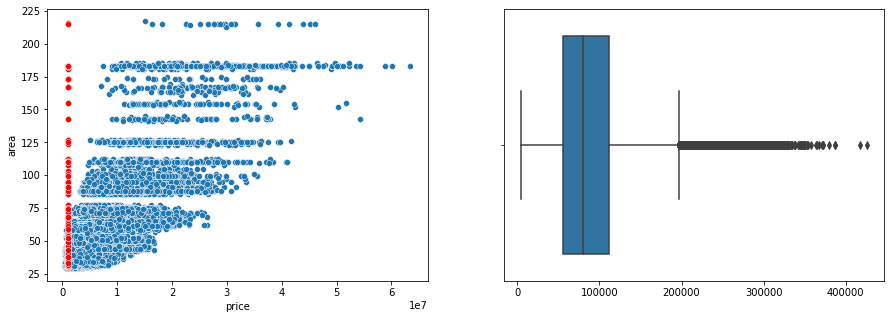

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(df_train.price, df_train.area, ax = ax[0])
sns.scatterplot(df_train[df_train.price == 10**6].price, df_train[df_train.price ==10**6].area, ax = ax[0], color = 'red')
sns.boxplot(df_train.price/df_train.area, ax = ax[1])

Объекты с ценой = 1 000 000, странно себя ведут. Посмотрим что выйдет если их удалить.

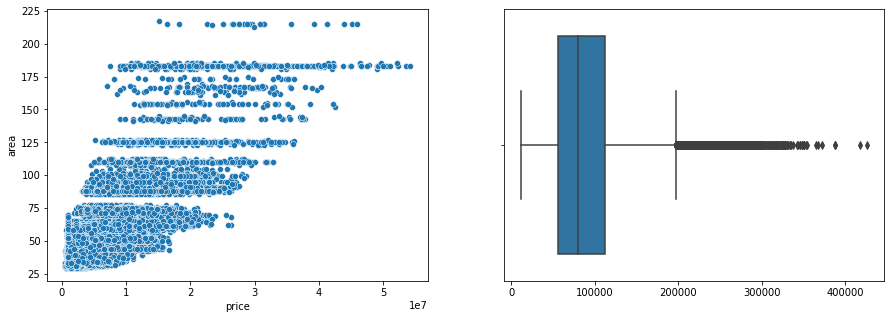

In [ ]:
ls = np.where((df_train.price==10**6), 0, 1)
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(df_train[ls == 1].price, df_train[ls == 1].area, ax = ax[0])
sns.boxplot(df_train[ls == 1].price/df_train[ls == 1].area, ax = ax[1])
plt.show()

In [ ]:
df_train = df_train[ls == 1]
df_train.shape

(99675, 25)

##1.6 Ключевые слова

In [ ]:
listkw = list(df_train.columns[9:22])
listkw

['kw1',
 'kw2',
 'kw3',
 'kw4',
 'kw5',
 'kw6',
 'kw7',
 'kw8',
 'kw9',
 'kw10',
 'kw11',
 'kw12',
 'kw13']

In [ ]:
df_train[listkw].sum()/df_train.shape[0]

kw1     0.056353
kw2     0.628121
kw3     0.007444
kw4     0.006672
kw5     0.003993
kw6     0.001816
kw7     0.000823
kw8     0.007354
kw9     0.007856
kw10    0.002007
kw11    0.000271
kw12    0.001776
kw13    0.000231
dtype: float64

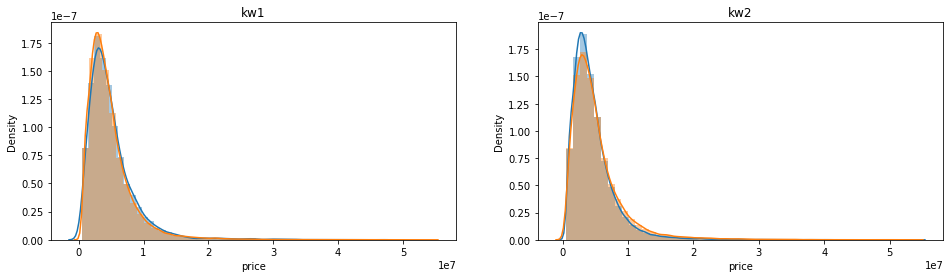

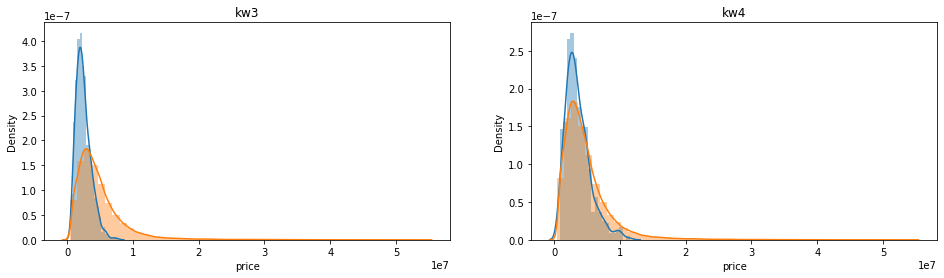

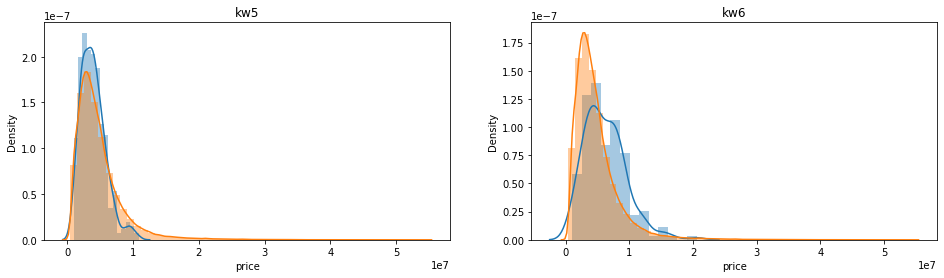

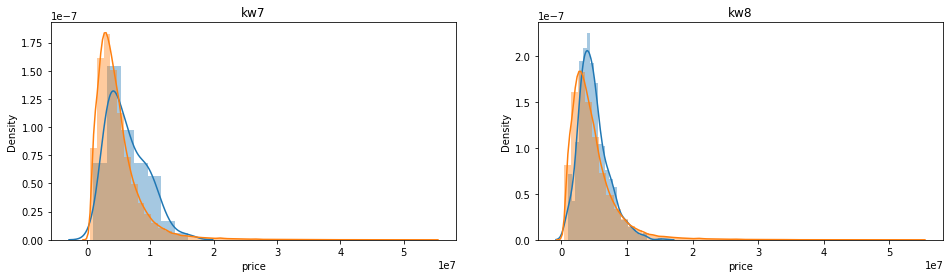

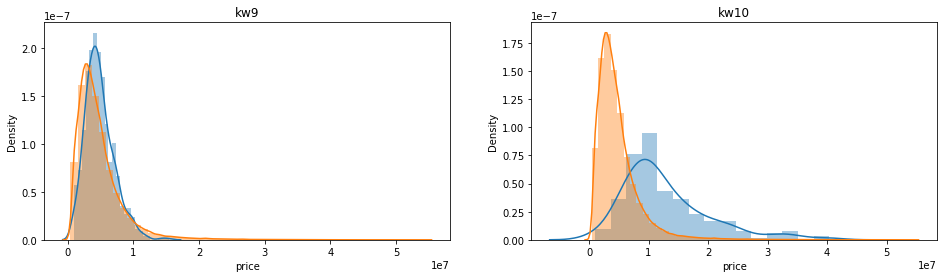

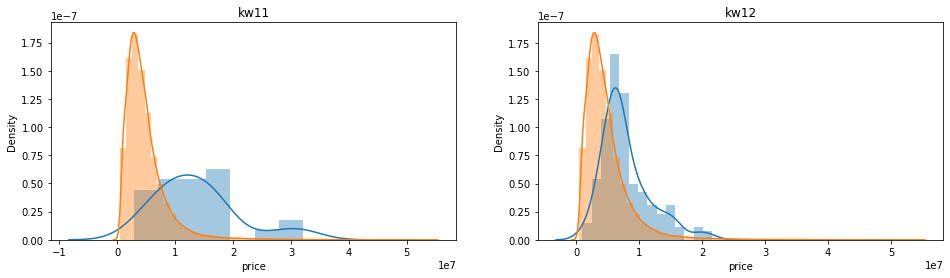

In [ ]:
for i in range(1, 7):
  col1 = 'kw' + str(2*i-1)
  col2 =  'kw' + str(2*i)
  fig, ax = plt.subplots(1,2, figsize = (16, 4))

  sns.distplot(df_train[df_train[col1] == 1].price, ax = ax[0])
  sns.distplot(df_train[df_train[col1] == 0].price, ax = ax[0])
  ax[0].set_title(col1)

  sns.distplot(df_train[df_train[col2] == 1].price, ax = ax[1])
  sns.distplot(df_train[df_train[col2] == 0].price, ax = ax[1])
  ax[1].set_title(col2)
  plt.show()

Первое и второе слово не дают значимых отличий в распределении цены, можно пробовать их удалить.

In [ ]:
trash_feat = ['kw1', 'kw2']

#2 Предобработка признаков

##2.1 Заполнение пропусков

###2.1.1 Признак *biuld_tech*

Заполнять пропуски будем с помощью других моделей. Но по таблице с корреляцией видно, что есть явно заметная связь с признаком *balcon*, а также с рядом других признаков.

In [ ]:
df_train.columns[9:]

Index(['kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10',
       'kw11', 'kw12', 'kw13', 'price', 'Month', 'Season'],
      dtype='object')

In [ ]:
df_train.build_tech.unique()

array([nan,  0.,  1.,  2.])

In [ ]:
y = df_train['price']
X_train = df_train.drop('price', axis = 1)
X_train = pd.concat([X_train, df_test], axis = 0)

X_train.shape

(199675, 24)

Деление датасета.

In [ ]:
X_train_notnull = X_train.copy()[X_train.build_tech.notnull()]
X_train_isnull = X_train.copy()[X_train.build_tech.isnull()]

In [ ]:
y_train_notnull = X_train_notnull['build_tech']
X_train_notnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)
X_train_isnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)

In [ ]:
xgb_f = CatBoostClassifier(n_estimators = 100, max_depth = 10, 
                           learning_rate = 0.05, verbose = 0)
X_train_notn, X_test_notn, y_train_notn, y_test_notn = train_test_split(X_train_notnull, y_train_notnull, test_size = 0.28)
X_train_notn.shape, y_train_notn.shape

((100548, 21), (100548,))

In [ ]:
cross_mas = cross_validate(xgb_f, X_train_notn, y_train_notn, cv = 5, 
                           scoring = ['accuracy', 'f1_micro', 'f1_macro'], n_jobs = -1)

In [ ]:
cross_mas

{'fit_time': array([24.20540524, 24.16250157, 24.66576433, 24.69488859, 11.76039362]),
 'score_time': array([0.08641911, 0.07653546, 0.07491827, 0.06772518, 0.04140353]),
 'test_accuracy': array([0.93391348, 0.93754351, 0.93888613, 0.94221493, 0.93828634]),
 'test_f1_macro': array([0.93416916, 0.93812659, 0.94075721, 0.94536133, 0.93584915]),
 'test_f1_micro': array([0.93391348, 0.93754351, 0.93888613, 0.94221493, 0.93828634])}

In [ ]:
xgb_f.fit(X_train_notn, y_train_notn)

In [ ]:
y_pred = xgb_f.predict(X_test_notn)
confusion_matrix(y_test_notn, y_pred)

array([[19653,   342,    19],
       [ 1821, 15403,    33],
       [   44,   106,  1682]])

In [ ]:
xgb_f.fit(X_train_notnull, y_train_notnull)

In [ ]:
y_fill = xgb_f.predict(X_train_isnull)

In [ ]:
X_train_isnull['build_tech'] = y_fill
X_train_notnull['build_tech'] = y_train_notnull
df_trainn = pd.concat([X_train_notnull, X_train_isnull], axis = 0)

In [ ]:
filled_build = df_trainn.sort_index()['build_tech']

###2.1.2 Признак *metro_dist*

In [ ]:
X_train_notnull = X_train.copy()[X_train.metro_dist.notnull()]
X_train_isnull = X_train.copy()[X_train.metro_dist.isnull()]

y_train_notnull = X_train_notnull['metro_dist']
X_train_notnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)
X_train_isnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)

forest = RandomForestClassifier(n_estimators = 100, max_depth = 10,  n_jobs = -1)
xgb_f = XGBClassifier(n_estimators = 100, max_depth = 10)
X_train_notn, X_test_notn, y_train_notn, y_test_notn = train_test_split(X_train_notnull, y_train_notnull, test_size = 0.28)
X_train_notn.shape, y_train_notn.shape

((136512, 21), (136512,))

In [ ]:
cross_mas = cross_validate(forest, X_train_notn, y_train_notn, cv = 5, 
                           scoring = ['accuracy', 'f1_micro', 'f1_macro'], n_jobs = -1)
cross_mas

{'fit_time': array([10.65517664, 10.45627475, 10.54914355, 10.71474266,  5.13143301]),
 'score_time': array([0.46873856, 0.46989036, 0.57425761, 0.48339558, 0.33212447]),
 'test_accuracy': array([0.36805479, 0.36794491, 0.367702  , 0.3681049 , 0.36773863]),
 'test_f1_macro': array([0.07824863, 0.07872573, 0.0784031 , 0.07866394, 0.07766468]),
 'test_f1_micro': array([0.36805479, 0.36794491, 0.367702  , 0.3681049 , 0.36773863])}

Как видно по результатам леса (и по таблице корреляции) расстояние до метро только имеет какую-то связь с ценой.

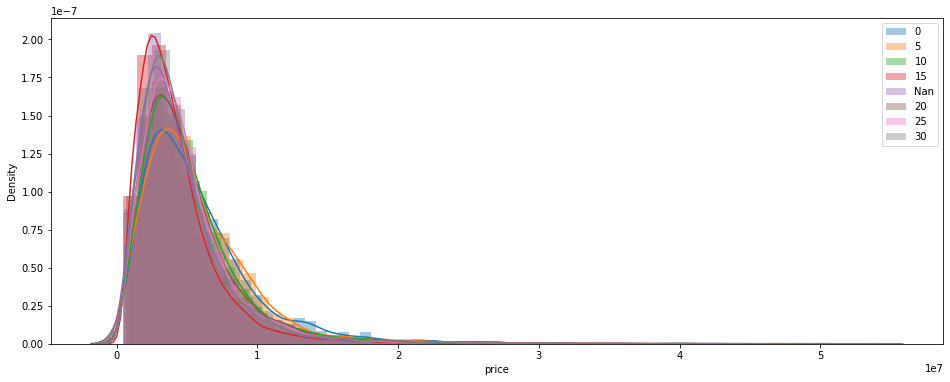

In [ ]:
plt.figure(figsize = (16, 6))
sns.distplot(df_train[df_train.metro_dist == 0].price, label = '0')
sns.distplot(df_train[df_train.metro_dist == 5].price, label = '5')
sns.distplot(df_train[df_train.metro_dist == 10].price, label = '10')
sns.distplot(df_train[df_train.metro_dist == 30].price, label = '15')
sns.distplot(df_train[df_train.metro_dist.isnull()].price, label = 'Nan')
sns.distplot(df_train[df_train.metro_dist == 15].price, label = '20')
sns.distplot(df_train[df_train.metro_dist == 20].price, label = '25')
sns.distplot(df_train[df_train.metro_dist == 25].price, label = '30')
plt.legend()
plt.show()

Самое похожее распределение это при значении 20, однако ввиду того что ориентироваться на целевую переменную - не самая лучшая затея и результатов леса по обучению на этой выборке, лучше всего описать пропуски новым значением. К тому же пропусков много, поэтому если заполнить каким-нибудь уже имеющимся значением, то мы значительно подпортим статистику для значений.

###2.1.3 Признак g_lift

In [ ]:
X_train.g_lift.describe()

count    139594.000000
mean          0.496784
std           0.499991
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: g_lift, dtype: float64

In [ ]:
X_train_notnull = X_train.copy()[X_train.g_lift.notnull()]
X_train_isnull = X_train.copy()[X_train.g_lift.isnull()]

y_train_notnull = X_train_notnull['g_lift']
X_train_notnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)
X_train_isnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)

forest = RandomForestClassifier(n_estimators = 100, max_depth = 15, n_jobs = -1)
X_train_notn, X_test_notn, y_train_notn, y_test_notn = train_test_split(X_train_notnull, y_train_notnull, test_size = 0.28)
X_train_notn.shape, y_train_notn.shape

((100507, 21), (100507,))

In [ ]:
X_train.shape

(199675, 24)

In [ ]:
cross_mas = cross_validate(forest, X_train_notn, y_train_notn, cv = 5, 
                           scoring = ['accuracy', 'f1_micro', 'f1_macro'], n_jobs = -1)
cross_mas

{'fit_time': array([10.13280654, 10.16553473, 10.24094343, 10.20574808,  4.97978806]),
 'score_time': array([0.43147707, 0.44373846, 0.43219662, 0.44374967, 0.33214426]),
 'test_accuracy': array([0.49835837, 0.50094518, 0.49793543, 0.50236307, 0.4989304 ]),
 'test_f1_macro': array([0.49051605, 0.4836208 , 0.48996373, 0.49261623, 0.48821169]),
 'test_f1_micro': array([0.49835837, 0.50094518, 0.49793543, 0.50236307, 0.4989304 ])}

Снова видим отвратительную аппроксимацию другими признаками. Попробуем взглянуть на распределение целевой переменной.

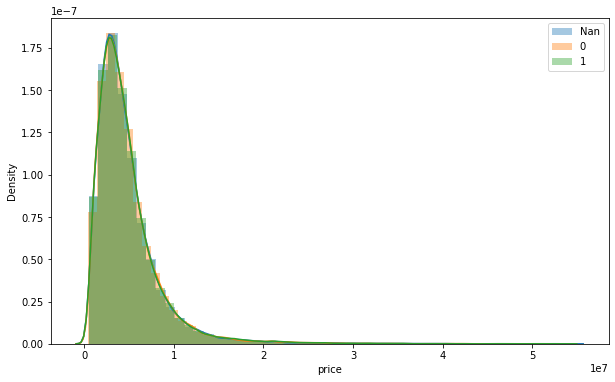

In [ ]:
plt.figure(figsize = (10, 6))
sns.distplot(df_train[df_train.g_lift.isnull()].price, label = 'Nan')
sns.distplot(df_train[df_train.g_lift == 0].price, label = '0')
sns.distplot(df_train[df_train.g_lift == 1].price, label = '1')
plt.legend()
plt.show()

Возможно, что лучше вообще удалить этот признак, распределения цен, что с лифтом, что без него, что с пропусками: везде почти одинаковое. 

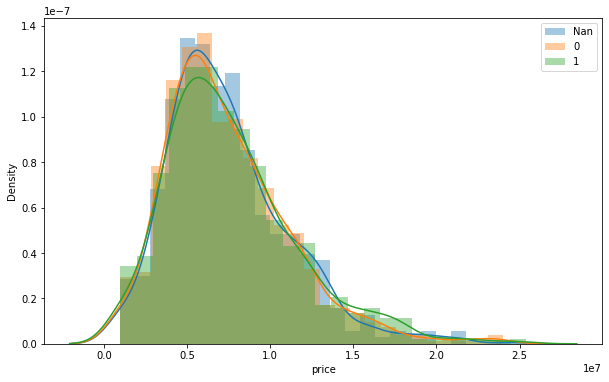

In [ ]:
high_ = df_train[df_train.floor > 15]
plt.figure(figsize = (10, 6))
sns.distplot(high_[high_.g_lift.isnull()].price, label = 'Nan')
sns.distplot(high_[high_.g_lift == 0].price, label = '0')
sns.distplot(high_[high_.g_lift == 1].price, label = '1')
plt.legend()
plt.show()

In [ ]:
trash_feat.append('g_lift')
trash_feat.append('metro_dist')

##2.2 Собираем все в кучу, избавляемся от мусора

Можно запускать, только начиная с пункта 3, там есть функция для преобразования данных 

In [ ]:
X_train.shape

(199675, 24)

In [ ]:
X_train['build_tech'] = filled_build
X_all = X_train.fillna(0).copy()#drop(trash_feat, axis = 1).copy()
X_all.shape

(199675, 24)

In [ ]:
#X_all['build_tech'] = X_all['build_tech'].apply(lambda x: str(int(x)))
X_all.isnull().sum().sum(), X_all.shape

(0, (199675, 24))

In [ ]:
X_all = X_all.applymap(lambda x: int(x))

In [ ]:
X_tr = X_all.iloc[: df_train.shape[0], :]
X_te = X_all.iloc[df_train.shape[0]: , :]
y_tr = y#(y-y.mean())/y.std()
cat_fs = X_all.columns[4:20]

In [ ]:
df_train.shape, df_test.shape, X_tr.shape, X_te.shape

((99675, 25), (100000, 24), (99675, 24), (100000, 24))

#3 Построение начальных моделей

In [ ]:
# Функция для преобразования данных, чтобы не запускать ячейки 1.2-2.2

def transform_data(df_train, df_test, drop_list = None):
  
  df_t_c = df_train.copy()
  df_te_c = df_test.copy()
  ls = np.where((df_train.price == 10**6), 0, 1)
  df_t_c = df_t_c[ls == 1]

  y = df_t_c['price']
  X_tra = df_t_c.drop('price', axis = 1)
  X_tra = pd.concat([df_t_c, df_te_c], axis = 0)

  X_train_notnull = X_tra.copy()[X_tra.build_tech.notnull()]
  X_train_isnull = X_tra.copy()[X_tra.build_tech.isnull()]

  y_train_notnull = X_train_notnull['build_tech']
  X_train_notnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)
  X_train_isnull.drop(['build_tech', 'metro_dist', 'g_lift'], axis = 1, inplace = True)

  xgb_f = XGBClassifier(n_estimators = 100, 
                             max_depth = 10)
  X_train_notn, X_test_notn, y_train_notn,y_test_notn = train_test_split(X_train_notnull, 
                                 y_train_notnull, test_size = 0.28)
  
  xgb_f.fit(X_train_notnull, y_train_notnull)
  y_fill = xgb_f.predict(X_train_isnull)

  X_train_isnull['build_tech'] = y_fill
  X_train_notnull['build_tech'] = y_train_notnull
  df_trainn = pd.concat([X_train_notnull, X_train_isnull], axis = 0)

  filled_build = df_trainn.sort_index()['build_tech']

  print(X_tra.shape)
  X_tra['build_tech'] = filled_build
  X_all = X_tra.fillna(-1)
  if drop_list:
    X_all = X_all.drop(drop_list, axis = 1)
    print(1)
  


  X_tr = X_all.iloc[: df_t_c.shape[0], :]
  X_te = X_all.iloc[df_t_c.shape[0]: , :]
  y_tr = y

  return X_tr, X_te, y_tr

In [ ]:
a1, a2, a3 = transform_data(df_train, df_test)

(195942, 25)


In [ ]:
#a3 = (a3 - a3.mean())/a3.std()
X_a = a1.drop('price', axis = 1)

In [ ]:
X_a = X_a.applymap(lambda x: int(x))
a2 = a2.applymap(lambda x: int(x))

In [ ]:
l = list(range(24))

Начальные модели на перекрестной проверке.

In [ ]:
svr = LinearSVR()
forest = RandomForestRegressor(n_estimators = 100, max_depth = 10, n_jobs = -1)
cat_boost = CatBoostRegressor(max_depth = 5, loss_function = 'RMSE', 
                              verbose = 0, cat_features = l, iterations = 100)
X_trai, X_tes, y_trai, y_tes = train_test_split(X_a, a3, test_size = 0.4)

In [ ]:
sc = {'mae': make_scorer(mean_absolute_error), 
      'r2': make_scorer(r2_score)}

In [ ]:
xgb = XGBRegressor(n_estimators = 100, max_depth = 10, objective = 'reg:squarederror')

In [ ]:
cv_mas_for = cross_validate(forest, X_trai, y_trai, cv = 5, 
                        scoring = sc, n_jobs = -1)
cv_mas_for

{'fit_time': array([15.82532954, 15.63089609, 15.55528927, 15.63775349,  7.87231255]),
 'score_time': array([0.20461798, 0.20576   , 0.22438717, 0.21150279, 0.10382724]),
 'test_mae': array([1441015.92452859, 1445910.79909482, 1457173.14679415,
        1454554.78269783, 1452727.89551407]),
 'test_r2': array([0.66097951, 0.68118817, 0.67384912, 0.66801701, 0.67152141])}

In [ ]:
cv_mas_xgb = cross_validate(xgb, X_trai, y_trai, cv = 5, 
                        scoring = sc, n_jobs = -1)
cv_mas_xgb

{'fit_time': array([18.45905852, 18.37538981, 18.20899653, 18.35895419, 10.73555493]),
 'score_time': array([0.1830883 , 0.1758616 , 0.17111373, 0.15800834, 0.12928963]),
 'test_mae': array([935947.0020846 , 933762.88265982, 960942.36082581, 965578.09864392,
        959570.22513137]),
 'test_r2': array([0.83571946, 0.84112573, 0.83816288, 0.82999896, 0.83369626])}

In [ ]:
cv_mas_cat = cross_validate(cat_boost, X_trai, y_trai, cv = 5, 
                        scoring = sc, n_jobs = -1)
cv_mas_cat

{'fit_time': array([5.46075392, 5.5875783 , 5.46180844, 5.47244883, 2.60158134]),
 'score_time': array([0.15833592, 0.17299485, 0.15803671, 0.16319871, 0.09286404]),
 'test_mae': array([742792.72295691, 759939.33478851, 755269.2514497 , 781963.26266852,
        768211.42665945]),
 'test_r2': array([0.8981424 , 0.89926644, 0.89357593, 0.88779156, 0.89008153])}

In [ ]:
cv_mas_lin = cross_validate(svr, X_trai, y_trai, cv = 5, 
                        scoring = sc, n_jobs = -1)
cv_mas_lin

{'fit_time': array([0.09370208, 0.13926625, 0.10052752, 0.0969739 , 0.08209443]),
 'score_time': array([0.00522518, 0.00441456, 0.0059936 , 0.00416899, 0.00278378]),
 'test_mae': array([1764436.50106973, 1785942.78254962, 1763894.76911807,
        1788600.17742027, 1787535.51484041]),
 'test_r2': array([0.41717181, 0.43642606, 0.43359867, 0.42575944, 0.42453801])}

In [ ]:
%%time
forest.fit(X_trai, y_trai)

CPU times: user 18.9 s, sys: 28.5 ms, total: 19 s
Wall time: 9.77 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
%%time
xgb.fit(X_trai, y_trai)

CPU times: user 13.3 s, sys: 22.7 ms, total: 13.3 s
Wall time: 13.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
%%time
cat_boost.fit(X_trai, y_trai)

CPU times: user 5.74 s, sys: 105 ms, total: 5.85 s
Wall time: 3.24 s


In [ ]:
%%time
svr.fit(X_trai, y_trai)

CPU times: user 66.2 ms, sys: 976 µs, total: 67.2 ms
Wall time: 69.6 ms


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

Лучший результат дал *catboost*. Будем использовать либо его, либо варианты для 
его стекинга.

In [ ]:
cat_imp = pd.Series(cat_boost.feature_importances_, 
                       index = X_trai.columns)
xgb_imp = pd.Series(xgb.feature_importances_, 
                       index = X_trai.columns)
forest_imp= pd.Series(forest.feature_importances_, 
                       index = X_trai.columns)

In [ ]:
imp_info = pd.DataFrame({'cat': cat_imp, 'xgb': xgb_imp, 'forest': forest_imp})
##cat_imp.sort_values(ascending = False)
#xgb_imp.sort_values(ascending = False)
#forest_imp.sort_values(ascending = False)

In [ ]:
# важность признаков в модели кат-буста
imp_info.sort_values(by = 'cat', ascending = False)

,cat,xgb,forest
area,52.369933,0.403686,0.769330
street_id,21.889537,0.053713,0.057018
rooms,13.730085,0.179921,0.020836
build_tech,7.696809,0.140872,0.056349
metro_dist,1.877138,0.024509,0.025452
floor,1.179053,0.012398,0.013720
n_photos,0.647872,0.028033,0.036171
Month,0.179376,0.010206,0.008289
Season,0.158645,0.011380,0.003036
g_lift,0.070044,0.007487,0.003319


In [ ]:
low_imp_feats = list(imp_info.sort_values(by = 'cat', ascending = False).index[-14:])

In [ ]:
y_pred_for = forest.predict(X_tes)
y_pred_xgb = xgb.predict(X_tes)
y_pred_cat = cat_boost.predict(X_tes)

In [ ]:
r2_score(y_tes, y_pred_xgb), mean_absolute_error(y_tes, y_pred_xgb), r2_score(y_tes, y_pred_cat), mean_absolute_error(y_tes, y_pred_cat)


(0.8444409159658077, 944898.2064737668, 0.898530044983453, 746282.7508721702)

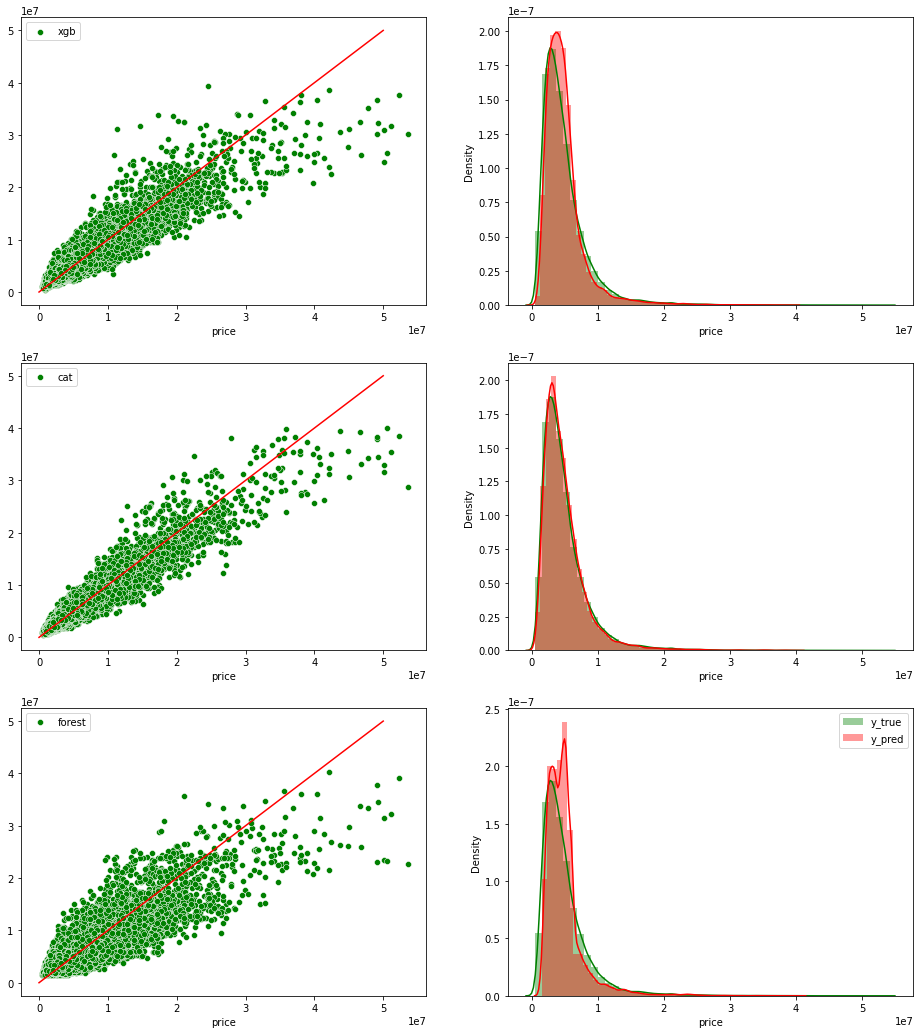

In [ ]:
# график точности на тестовых выборках у разных алгоритмов

fig, ax = plt.subplots(3, 2, figsize = (16, 18))
sns.scatterplot(y_tes, y_pred_xgb, color = 'green', label = 'xgb', ax = ax[0, 0])
sns.lineplot([0, 5*10**7], [0, 5*10**7], color = 'red', ax = ax[0, 0])
sns.distplot(y_tes, color = 'green', label = 'y_true', ax = ax[0, 1])
sns.distplot(y_pred_xgb, color = 'red', label = 'y_pred', ax = ax[0, 1])

sns.scatterplot(y_tes, y_pred_cat, color = 'green', label = 'cat', ax = ax[1, 0])
sns.lineplot([0, 5*10**7], [0, 5*10**7], color = 'red', ax = ax[1, 0])
sns.distplot(y_tes, color = 'green', label = 'y_true', ax = ax[1, 1])
sns.distplot(y_pred_cat, color = 'red', label = 'y_pred', ax = ax[1, 1])

sns.scatterplot(y_tes, y_pred_for, color = 'green', label = 'forest', ax = ax[2, 0])
sns.lineplot([0, 5*10**7], [0, 5*10**7], color = 'red', ax = ax[2, 0])
sns.distplot(y_tes, color = 'green', label = 'y_true', ax = ax[2, 1])
sns.distplot(y_pred_for, color = 'red', label = 'y_pred', ax = ax[2, 1])
plt.legend()
plt.show()

#4 Оптимизация моделей

##4.1 CatBoost

In [ ]:
l = list(range(10))
l.pop(3)
print(l)
a1, a2, a3 = transform_data(df_train, df_test, drop_list = low_imp_feats)
X_a = a1.drop('price', axis = 1)

[0, 1, 2, 4, 5, 6, 7, 8, 9]
(195942, 25)
1


In [ ]:
X_a.isnull().sum()

street_id     0
build_tech    0
floor         0
area          0
rooms         0
metro_dist    0
g_lift        0
n_photos      0
Month         0
Season        0
dtype: int64

In [ ]:
X_a = X_a.applymap(lambda x: int(x))
X_trai, X_tes, y_trai, y_tes = train_test_split(X_a, a3, test_size = 0.4)

In [ ]:
cat_ = CatBoostRegressor(depth = 12, cat_features = l, iterations = 500)

In [ ]:
def get_mae(num_iter, Xtrain, ytrain, Xtest, ytest):
  model =  CatBoostRegressor(depth = 12, 
                             cat_features = l, 
                             iterations = num_iter, 
                             verbose = 0)
  model.fit(Xtrain, ytrain)
  pr = model.predict(Xtrain)
  preds = model.predict(Xtest)
  score_train = mean_absolute_error(ytrain, pr)
  mae = mean_absolute_error(ytest, preds)
  return mae, score_train

In [ ]:
list_res_plot = []
for n in [10, 50, 75, 100, 125, 150, 200]:
  list_res_plot.append(get_mae(n, X_trai, y_trai, X_tes, y_tes))

In [ ]:
list_res_plot

[(744321.4225904098, 715676.1653564018),
 (713220.955736876, 630904.482653338),
 (717157.2156071772, 608925.3899000094),
 (720062.5098275425, 590895.5096966015),
 (713255.5606697607, 592231.4717756094),
 (713583.965704724, 581703.7720601389),
 (484359.6432598879, 396244.6508828322)]

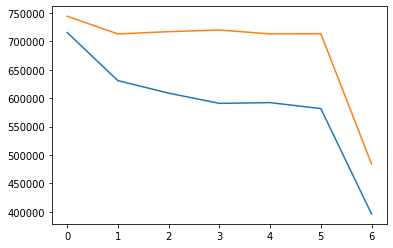

In [ ]:
plt.plot(np.array(list_res_plot)[:, 1])
plt.plot(np.array(list_res_plot)[:, 0])

In [ ]:
cat_.fit(X_trai, y_trai, eval_set = (X_tes, y_tes))

Learning rate set to 0.152651
0:	learn: 3211718.3379218	test: 3292587.6065071	best: 3292587.6065071 (0)	total: 419ms	remaining: 3m 29s
1:	learn: 2852424.3757909	test: 2921624.6348857	best: 2921624.6348857 (1)	total: 838ms	remaining: 3m 28s
2:	learn: 2552254.7118480	test: 2610811.5502365	best: 2610811.5502365 (2)	total: 1.22s	remaining: 3m 21s
3:	learn: 2304177.4096806	test: 2346239.5701646	best: 2346239.5701646 (3)	total: 1.67s	remaining: 3m 27s
4:	learn: 2096178.4434643	test: 2126772.3771029	best: 2126772.3771029 (4)	total: 2.05s	remaining: 3m 22s
5:	learn: 1927854.3607569	test: 1941552.4231600	best: 1941552.4231600 (5)	total: 2.41s	remaining: 3m 18s
6:	learn: 1788312.7600358	test: 1791153.6963024	best: 1791153.6963024 (6)	total: 2.81s	remaining: 3m 17s
7:	learn: 1671720.0949591	test: 1666686.7978031	best: 1666686.7978031 (7)	total: 3.23s	remaining: 3m 18s
8:	learn: 1577056.2585057	test: 1562176.7496760	best: 1562176.7496760 (8)	total: 3.66s	remaining: 3m 19s
9:	learn: 1503818.9545494

In [ ]:
y_cat = cat_.predict(X_tes)
r2_score(y_tes, y_cat), mean_absolute_error(y_tes, y_cat)

(0.961221365800542, 463033.92056353606)

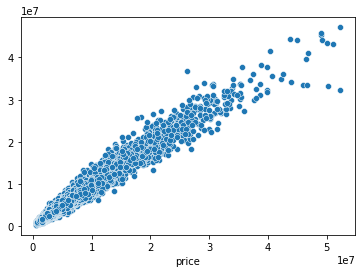

In [ ]:
sns.scatterplot(y_tes, y_cat)

##4.4 Попытка применить стэкинг к моделям

Он не дал значимо лучших результатов на каггл.

In [ ]:
estims = [('forest', RandomForestRegressor(n_estimators = 500, 
                                           max_depth = 8, 
                                           n_jobs = -1)),
          #('xgb', XGBRegressor(learning_rate = 0.081, 
                                            #max_depth = 8, 
                                            #n_estimators = 500))
           ('cat', CatBoostRegressor(cat_features=l, iterations = 300, 
                                       max_depth = 10)),
           ('linsvr', LinearSVR())
          ]

l = list(range(24))
l.remove(3)

In [ ]:
stack = StackingRegressor(estims, 
                          LinearRegression(fit_intercept = False, normalize=True), 
                          cv = 3, n_jobs = -1)

In [ ]:
stack.fit(X_trai, y_trai)

StackingRegressor(cv=3,
                  estimators=[('forest',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=8,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_

In [ ]:
stack.score(X_tes, y_tes), stack.score(X_trai, y_trai)

(0.9607641978480634, 0.9718439848482886)

In [ ]:
y_ttt = stack.predict(X_trai)
y_ppp = stack.predict(X_tes)
mean_absolute_error(y_tes, y_ppp)

476101.50777608063

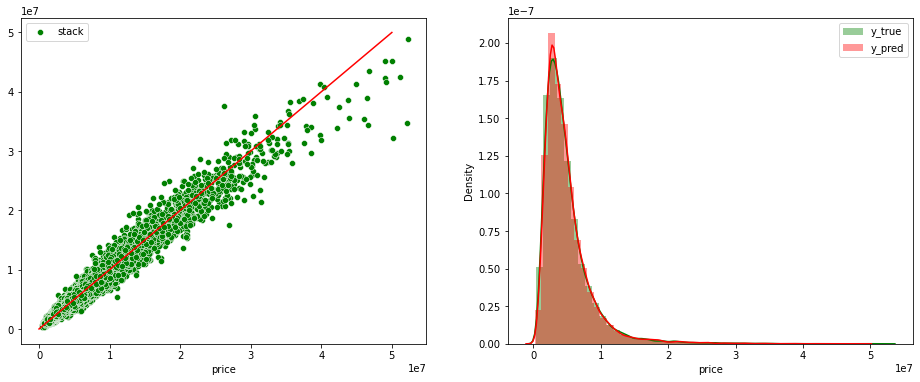

In [ ]:
# визуализация точности на тестовой выборке

fig, ax = plt.subplots(1, 2, figsize = (16, 6))
sns.scatterplot(y_tes, y_ppp, color = 'green', label = 'stack', ax = ax[0])
sns.lineplot([0, 5*10**7], [0, 5*10**7], color = 'red', ax = ax[0])
sns.distplot(y_tes, color = 'green', label = 'y_true', ax = ax[1])
sns.distplot(y_ppp, color = 'red', label = 'y_pred', ax = ax[1])

plt.legend()
plt.show()

##3.2 Результат выгружаем на каггл

In [ ]:
X_a.columns

Index(['street_id', 'build_tech', 'floor', 'area', 'rooms', 'metro_dist',
       'g_lift', 'n_photos', 'Month', 'Season'],
      dtype='object')

In [ ]:
stack.fit(X_a, a3)

StackingRegressor(cv=3,
                  estimators=[('forest',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=8,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_

In [ ]:
a2 = a2.applymap(lambda x: int(x))
ans = stack.predict(a2.drop('price', axis = 1))

In [ ]:
pd.DataFrame({'id': range(100000, 200000), 'price': ans}).to_csv('ans_xgb_opt_b.csv', index = False)

In [ ]:
pd.DataFrame({'id': list(a2.index), 'price': ans})

,id,price
0,100000,1.869692e+06
1,100001,2.316787e+06
2,100002,5.385798e+06
3,100003,1.484553e+06
4,100004,6.483098e+06
...,...,...
99995,199995,1.507377e+07
99996,199996,2.073360e+06
99997,199997,2.743776e+06
99998,199998,3.368691e+06


#4 Попытка в Байессовскую оптимизацию по оптимизации моделей

Лучше не запускать

In [ ]:
# результата на каггл не дало 


def estim_b(eta, n_estimators, max_depth):
  params = {'objective': 'reg:squarederror',
            'base_score': 0,
            'eta': eta, 
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth)}
  #cv_mas_xgb = cross_val_score(XGBRegressor(**params), X_train, y_train, cv = 5, 
                        #scoring = 'r2', n_jobs = -1)
  xg = XGBRegressor(**params)
  xg.fit(X_train, y_train)
  y_p = xg.predict(X_test)

  return r2_score(y_test, y_p)#cv_mas_xgb.mean()

params_for_opt = {'eta': (0.01, 0.1),
                  'n_estimators': (200, 500),
                  'max_depth': (5, 15)}

In [ ]:
max_b = BayesianOptimization(estim_b, params_for_opt)

NameError: ignored

In [ ]:
max_b.maximize(init_points = 10, acq = 'ei')

In [ ]:
xg = XGBRegressor(eta = 0.02688, max_depth = 10, n_estimators=280, objective='reg:squarederror')
xg.fit(X_train, y_train)

In [ ]:
y_p = xg.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_p), r2_score(y_test, y_p)

In [ ]:
mean_absolute_error(y_test, y_p-110000)

In [ ]:
def estim_cat(eta, n_estimators, max_depth):
  params = {'eta': eta, 
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth)}
  cv_mas_xgb = cross_val_score(XGBRegressor(**params), X_train, y_train, cv = 5, 
                        scoring = 'r2', n_jobs = -1)
  return cv_mas_xgb.mean()

params_for_opt = {'eta': (0.1, 0.8),
                  'n_estimators': (100, 300),
                  'max_depth': (5, 25)}

#5 В заключение

Результата меньше, чем в 956к добиться не удалось. Но есть идеи, благодаря которым возможно получится поднять качество.
* Дополнительно закодировать категориальные данные, где есть несколько меток
* Применить стекинг без признаков из начальных данных(только метапризнаки)
* Добавить больше моделей в стекинг
* Убрать определенное кол-во признаков, которые имеют малую важность в моделях
* В стекинге использовать на последней модели лин регрессор, перед этим лог-нормировать целевую выборку(оно имеет лог-нормальное распр. судя по графику)

К сожалению не хватило времени на реализацию всех идей.